In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import glob
from glob import glob
import os
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator


In [8]:
#Training set
d1=pd.read_csv("/home/worldline/data/CSVagg/aggtrx_20150423.csv")
d2=pd.read_csv("/home/worldline/data/CSVagg/aggtrx_20150424.csv")
d3=pd.read_csv("/home/worldline/data/CSVagg/aggtrx_20150425.csv")
d4=pd.read_csv("/home/worldline/data/CSVagg/aggtrx_20150426.csv")
d5=pd.read_csv("/home/worldline/data/CSVagg/aggtrx_20150427.csv")
d6=pd.read_csv("/home/worldline/data/CSVagg/aggtrx_20150428.csv")
d7=pd.read_csv("/home/worldline/data/CSVagg/aggtrx_20150429.csv")

In [9]:
d=[d1,d2,d3,d4,d5,d5,d6,d7]
df=pd.concat(d, ignore_index=True)
del df['TX_ACCEPTED']
del df['MIN_AMT_LAST_24H']
df_f1=df[df.TX_FRAUD==1]
df_f0=df[df.TX_FRAUD==0]
df_f0_s=df_f0.sample(len(df[df.TX_FRAUD==1]))
df_sl=[df_f0_s,df_f1]
df_s=pd.concat(df_sl,ignore_index=True)

In [10]:
#wazne! Factor to risk training
col_to_trans=['CARD_PAN_ID','TERM_MIDUID','TERM_MCC','TERM_COUNTRY','TX_3D_SECURE','LANGUAGE',
                  'GENDER','BROKER','CARD_BRAND','TX_TIME_HOURS','TX_TIME_DAYS','TERM_REGION','TERM_CONTINENT',
                  'TERM_MCCG','TERM_MCC_GROUP','LAST_MIDUID_TX','LAST_COUNTRY_TX','LAST_MCC_HIS']
for cols in col_to_trans:
    b=df_s.groupby(cols).sum()/df_s.TX_FRAUD.sum()
    df_s[cols]=df_s[cols].map(b.TX_FRAUD.to_dict())
df_s.TX_DATETIME=((pd.to_datetime(df_s.TX_DATETIME).dt.month)*100+pd.to_datetime(df_s.TX_DATETIME).dt.day)
df_s.to_csv("select/train_fact", index=False, header=True)


In [5]:
path = r'/home/worldline/data/CSVagg'

filenames =sorted(glob(path + "/*.csv"))
filenames_te=filenames[filenames.index(path+'/aggtrx_20150508.csv'):(filenames.index(path+'/aggtrx_20150531.csv')+1)]

In [ ]:
ROC_AUC=[]
Average_Precision=[]
Share=[]
Fraud_ID=[]
h2o.init(port=54331)
df_train = h2o.import_file("select/train_fact")
train_col=['TX_AMOUNT','AGE','TX_TIME_SECONDS','NB_TRX_LAST_24H','TERM_MIDUID','TERM_MCC','TERM_COUNTRY','TX_3D_SECURE',
           'LANGUAGE','GENDER','BROKER','CARD_BRAND','TX_TIME_HOURS','TX_TIME_DAYS','TERM_REGION','TERM_CONTINENT',
           'TERM_MCCG','TERM_MCC_GROUP','SUM_AMT_LAST_24H','TX_DIFF_LAST_TX','LAST_MIDUID_TX','LAST_COUNTRY_TX','LAST_MCC_HIS']
resp_col='TX_FRAUD'
model = H2ORandomForestEstimator(ntrees=10, max_depth=15, nfolds=10, binomial_double_trees=True, stopping_metric= "auc")
model.train(x=train_col, y=resp_col, training_frame=df_train)
for f in filenames_te:
    data=pd.read_csv(f)
    del data['TX_ACCEPTED']
    del data['MIN_AMT_LAST_24H']
    data.TX_FRAUD.apply(str)
    data=data[~ data.CARD_PAN_ID.isin(Fraud_ID)]
    for cols in col_to_trans:
        b=data.groupby(cols).sum()/data.TX_FRAUD.sum()
        data[cols]=data[cols].map(b.TX_FRAUD.to_dict())
    data.TX_DATETIME=((pd.to_datetime(data.TX_DATETIME).dt.month)*100+pd.to_datetime(data.TX_DATETIME).dt.day)
    specname = f.split("/")[-1]
    data.to_csv(os.path.join('select/%s'% specname))
    df_val=h2o.import_file(os.path.join('select/%s'% specname))
    pred=model.predict(df_val)
    pr=h2o.h2o.as_list(pred, use_pandas=True)
    tr=h2o.h2o.as_list(df_val, use_pandas=True)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(tr.TX_FRAUD,pr.predict,pos_label=1)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    ROC_AUC.append(roc_auc)
    precision, recall, thresholds=precision_recall_curve(tr.TX_FRAUD,pr.predict,pos_label=1)
    average_precision=average_precision_score(tr.TX_FRAUD, pr.predict)
    Average_Precision.append(average_precision)
    gr=(pd.concat([tr.CARD_PAN_ID,pr.predict,tr.TX_FRAUD],axis=1)).groupby("CARD_PAN_ID").max().sort_values("predict",ascending=False)
    per=((gr.head(100))[(gr.head(100)).TX_FRAUD==1].count()).TX_FRAUD
    Share.append(per)
    frauds=(gr.head(100))[(gr.head(100)).TX_FRAUD==1].index.tolist()
    Fraud_ID=Fraud_ID+list((gr.head(100))[(gr.head(100)).TX_FRAUD==1].index.unique())
Final_table=pd.DataFrame({"ROC_AUC": ROC_AUC,
                          "Average_Precision": Average_Precision,
                          "Share": Share})
A_P_m=Final_table.Average_Precision.mean()
AUC_m=Final_table.ROC_AUC.mean()
share_m=Final_table.Share.mean()
print("Average precision mean: {}, ROC AUC mean: {}, Share of fraudulant card in top 100 mean: {}".format(A_P_m, AUC_m, share_m))
h2o.cluster().shutdown()
        

In [11]:
h2o.cluster().shutdown()

H2O session _sid_b252 closed.


,0
0,0.333333
1,0.666667
2,1.000000


In [ ]:
ROC_AUC=[]
Average_Precision=[]
Share=[]
Fraud_ID=[]
for file in filenames_te:
    for f in file:
        h2o.cluster().shutdown()
        data=pd.read_csv(f)
        data.TX_FRAUD.apply(str)
        del data['TX_ACCEPTED']
        data=data[~ data.CARD_PAN_ID.isin(Fraud_ID)]
        col_to_trans_tr=['CARD_PAN_ID','TERM_MIDUID','TERM_MCC','TERM_COUNTRY','TX_3D_SECURE','LANGUAGE',
                            'GENDER','BROKER','CARD_BRAND','TX_TIME_HOURS','TX_TIME_DAYS','TERM_REGION','TERM_CONTINENT',
                            'TERM_MCCG','TERM_MCC_GROUP','TX_DIFF_LAST_TX','LAST_MIDUID_TX','LAST_COUNTRY_TX','LAST_MCC_HIS']
        for cols in col_to_trans_tr:
            b=data.groupby(cols).sum()/data.TX_FRAUD.sum()
            data[cols]=data[cols].map(b.TX_FRAUD.to_dict())
        data.TX_DATETIME=((pd.to_datetime(data.TX_DATETIME).dt.month)*100+pd.to_datetime(data.TX_DATETIME).dt.day)
        
        specname = f.split("/")[-1]
        data.to_csv(os.path.join('select/%s'% specname))
        h2o.init(port=54331)
        df_train = h2o.import_file("select/train_all")
        df_val=h2o.import_file(os.path.join('select/%s'% specname))
        train_col=['TX_AMOUNT','AGE','TX_TIME_SECONDS','NB_TRX_LAST_24H','TERM_MIDUID','TERM_MCC','TERM_COUNTRY','TX_3D_SECURE',
                  'LANGUAGE','GENDER','BROKER','CARD_BRAND','TX_TIME_HOURS','TX_TIME_DAYS','TERM_REGION','TERM_CONTINENT','TERM_MCCG','TERM_MCC_GROUP',
                  'SUM_AMT_LAST_24H','TX_DIFF_LAST_TX','LAST_MIDUID_TX','LAST_COUNTRY_TX','LAST_MCC_HIS']
        resp_col='TX_FRAUD'
        model = H2ORandomForestEstimator(ntrees=10, max_depth=15, nfolds=10, binomial_double_trees=True, stopping_metric= "auc")
        model.train(x=train_col, y=resp_col, training_frame=df_train)
        pred=model.predict(df_val)
        pr=h2o.h2o.as_list(pred, use_pandas=True)
        tr=h2o.h2o.as_list(df_val, use_pandas=True)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(tr.TX_FRAUD,pr.predict,pos_label=1)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        ROC_AUC.append(roc_auc)
        precision, recall, thresholds=precision_recall_curve(tr.TX_FRAUD,pr.predict,pos_label=1)
        average_precision=average_precision_score(tr.TX_FRAUD, pr.predict) 
        Average_Precision.append(average_precision)
        n=[tr.CARD_PAN_ID,pr.predict,tr.TX_FRAUD]
        new=pd.concat(n,axis=1)
        gr=new.groupby("CARD_PAN_ID").max().sort_values("predict",ascending=False)
        top=gr.head(100)
        per=(top[top.TX_FRAUD==1].count())/100
        perc=per.TX_FRAUD # frauds in top 100
        Share.append(perc)
        frauds=top[top.TX_FRAUD==1].index.tolist()
        Fraud_ID=Fraud_ID+list(top[top.TX_FRAUD==1].index.unique())
    print('The {} is done!'.format(file))
    Final_table=pd.DataFrame({"ROC_AUC": ROC_AUC,
                              "Average_Precision": Average_Precision,
                              "Share": Share})
A_P_m=Final_table.Average_Precision.mean()
AUC_m=Final_table.ROC_AUC.mean()
share_m=Final_table.Share.mean()
print("Average precision mean: {}, ROC AUC mean: {}, Share of fraudulant card in top 100 mean: {}".format(A_P_m, AUC_m, share_m))
Final_table
h2o.cluster().shutdown()


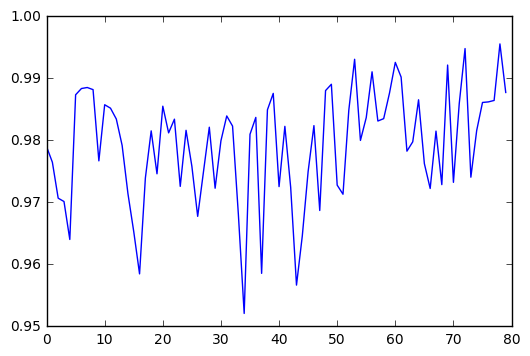

In [17]:
plt.plot(Final_table.ROC_AUC)

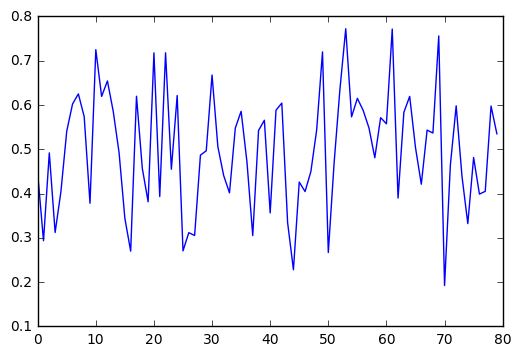

In [18]:
plt.plot(Final_table.Average_Precision)

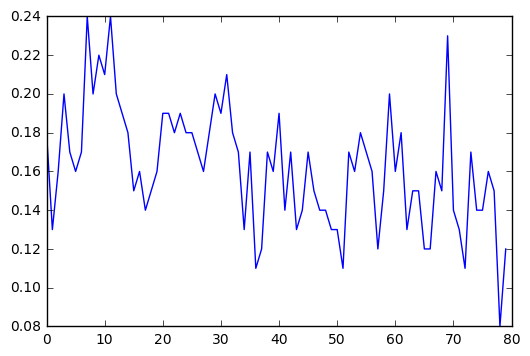

In [19]:
plt.plot(Final_table.Share)